# Proyek Analisis Data Online Retail: End-to-End Pipeline
Proyek ini bertujuan untuk menganalisis perilaku belanja pelanggan dan performa penjualan melalui alur kerja data yang lengkap, mulai dari **Data Cleaning**, integrasi **Database (PostgreSQL)**, hingga analisis lanjutan seperti **RFM Segmentation** dan **Market Basket Analysis**.

## 1. Memuat Data dan Library
Langkah pertama adalah menyiapkan lingkungan kerja dengan memanggil library utama untuk manipulasi data dan visualisasi.

### Catatan Teknis:
* **Encoding:** Dataset ini menggunakan `encoding='ISO-8859-1'` karena mengandung karakter khusus internasional.
* **Auto-Separator:** Menggunakan fungsi `sep=None` agar sistem mendeteksi pemisah kolom secara otomatis.

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Gunakan sep=None dan engine='python' agar Pandas mendeteksi pemisah secara otomatis
try:
    df = pd.read_csv('data/Online Retail Dataset.csv', sep=None, engine='python', encoding='ISO-8859-1')
    print("Data Berhasil Dimuat dengan Auto-Separator!")
except Exception as e:
    print(f"Gagal memuat data: {e}")

# Melihat 5 baris pertama
df.head()

Data Berhasil Dimuat dengan Auto-Separator!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## 2. Inspeksi Data (Data Discovery)
Tahap ini merupakan fase krusial untuk memahami karakteristik dataset sebelum melakukan transformasi lebih lanjut. Fokus utama pada tahap ini adalah mendeteksi masalah kualitas data (data quality issues) yang dapat memengaruhi akurasi analisis.

Aspek yang diinspeksi meliputi:

Missing Values: Mengidentifikasi kolom dengan data kosong, terutama pada CustomerID dan Description.

Data Consistency: Memastikan tipe data pada setiap kolom sudah tepat (misalnya, memastikan InvoiceDate dapat dikonversi menjadi format waktu).

Statistical Anomalies: Mendeteksi nilai yang tidak wajar melalui ringkasan statistik, seperti:

Quantity negatif (indikasi barang retur atau rusak).

UnitPrice bernilai 0 atau negatif (indikasi penyesuaian stok atau kesalahan input).

In [2]:
# 1. Cek informasi dasar dan tipe data
print("--- Informasi Struktur Dataset ---")
df.info()

# 2. Cek jumlah nilai yang hilang
print("\n--- Analisis Missing Values ---")
print(df.isnull().sum())

# 3. Cek statistik deskriptif untuk deteksi anomali
print("\n--- Ringkasan Statistik ---")
display(df.describe())

--- Informasi Struktur Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542014 entries, 0 to 542013
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    542014 non-null  object 
 1   StockCode    542014 non-null  object 
 2   Description  540560 non-null  object 
 3   Quantity     542014 non-null  int64  
 4   InvoiceDate  542014 non-null  object 
 5   UnitPrice    542014 non-null  float64
 6   CustomerID   406934 non-null  float64
 7   Country      542014 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

--- Analisis Missing Values ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

--- Ringkasan Statistik ---


,Quantity,UnitPrice,CustomerID
count,542014.000000,542014.000000,406934.000000
mean,9.555285,4.611339,15287.724582
std,218.060485,96.750980,1713.702628
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 3. Proses Pembersihan Data (Data Cleaning)
Pada tahap ini, kita akan menjalankan serangkaian prosedur pembersihan untuk memastikan integritas data. Langkah-langkah yang diambil meliputi:

* **Menghapus Data Tanpa Identitas:** Menghapus baris dengan `CustomerID` kosong karena analisis perilaku pelanggan tidak dapat dilakukan tanpa ID unik.
* **Koreksi Tipe Data:** Mengubah `InvoiceDate` menjadi format *datetime* untuk analisis berbasis waktu dan `CustomerID` menjadi *integer*.
* **Penyaringan Transaksi:**
    * Menghapus transaksi yang dibatalkan (kode invoice diawali 'C').
    * Menghapus nilai negatif atau nol pada `Quantity` dan `UnitPrice` untuk menghindari bias pada total pendapatan.
* **Feature Engineering:** Membuat kolom `TotalAmount` sebagai indikator utama nilai transaksi (Quantity × Unit Price).

In [3]:
# 1. Menghapus baris yang tidak memiliki CustomerID
# Karena kita akan analisis pelanggan, ID sangat krusial.
df.dropna(subset=['CustomerID'], inplace=True)

# 2. Mengubah tipe data CustomerID menjadi Integer (agar tidak muncul .0 di belakangnya)
df['CustomerID'] = df['CustomerID'].astype(int)

# 3. Mengubah tipe data InvoiceDate menjadi Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 4. Menangani transaksi yang dibatalkan (InvoiceNo yang diawali 'C')
# Kita hapus data pembatalan agar tidak mengganggu analisis total penjualan
df = df[~df['InvoiceNo'].str.contains('C', na=False)]

# 5. Menghapus data dengan Quantity atau UnitPrice <= 0
# (Data sampah yang sering muncul di dataset ini karena kesalahan input/adjust stock)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 6. Membuat kolom baru 'TotalAmount' (Quantity * UnitPrice)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print("Proses Cleaning Selesai!")
print(f"Jumlah baris setelah dibersihkan: {len(df)}")

Proses Cleaning Selesai!
Jumlah baris setelah dibersihkan: 397988


## 4. Validasi Akhir dan Ekspor Data
Setelah pembersihan selesai, langkah krusial berikutnya adalah melakukan verifikasi untuk memastikan tidak ada lagi data yang kosong atau tidak konsisten sebelum masuk ke tahap analisis mendalam.

* **Pengecekan Ulang:** Memastikan jumlah nilai kosong (*missing values*) di semua kolom adalah nol.
* **Inspeksi Akhir:** Melihat cuplikan data yang telah dibersihkan.
* **Output:** Menyimpan dataset yang sudah rapi ke dalam file `Online_Retail_Cleaned.csv` agar siap digunakan untuk analisis EDA dan RFM tanpa perlu mengulang proses pembersihan.

In [ ]:
# Cek apakah masih ada missing values
print("Sisa Missing Values:")
print(df.isnull().sum())

# Tampilkan 5 data teratas yang sudah bersih
display(df.head())

# Simpan ke file baru untuk digunakan di tahap portofolio selanjutnya
df.to_csv('data/Online_Retail_Cleaned.csv', index=False)
print("File 'Online_Retail_Cleaned.csv' siap digunakan!")

Sisa Missing Values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalAmount    0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


File 'Online_Retail_Cleaned.csv' siap digunakan!


## 5. Data Warehousing (Integrasi SQL)
Setelah tahap pembersihan data (*Data Cleaning*), langkah strategis selanjutnya adalah membangun **Pipeline ETL** (Extract, Transform, Load) untuk menyimpan data ke dalam database relasional.

### Mengapa Tahap Ini Penting?
Dalam lingkungan profesional, data tidak hanya berhenti di file CSV. Menyimpan data di **PostgreSQL** memungkinkan:
* **Single Source of Truth:** Seluruh departemen (Marketing, Finance, Analyst) mengakses data yang sudah tervalidasi dari satu sumber pusat.
* **Integrasi Alat BI:** Memudahkan koneksi langsung ke alat visualisasi seperti **Power BI** atau **Tableau**.
* **Keamanan Data:** Memberikan kontrol akses yang lebih baik dibandingkan file Excel/CSV.

### Proses yang Dilakukan:
1. **Database Connection:** Membangun koneksi antara Python dan PostgreSQL menggunakan `SQLAlchemy` dan driver `pg8000`.
2. **Data Loading (Load):** Memindahkan DataFrame dari memori Python ke dalam tabel permanen `online_retail_clean`.
3. **Data Integrity:** Menjamin konsistensi tipe data (seperti format tanggal dan angka) tetap terjaga di dalam database.

In [5]:
import pandas as pd
from sqlalchemy import create_engine

# Konfigurasi Koneksi Database
user = 'postgres'
password = 'Masuk123*' 
host = 'localhost'
port = '5432'
db_name = 'retail_db'

# Membuat engine koneksi menggunakan pg8000
engine = create_engine(f'postgresql+pg8000://{user}:{password}@{host}:{port}/{db_name}')

try:
    # Kirim data bersih ke PostgreSQL
    df.to_sql('online_retail_clean', engine, if_exists='replace', index=False)
    print("Sukses! Data telah disimpan di PostgreSQL dalam tabel 'online_retail_clean'.")
except Exception as e:
    print(f"Terjadi kesalahan: {e}")

Sukses! Data telah disimpan di PostgreSQL dalam tabel 'online_retail_clean'.


## 6. Pengambilan Data (*Data Retrieval*)
Langkah ini merupakan tahap krusial untuk memastikan prinsip **Single Source of Truth** dalam proyek ini. Alih-alih menggunakan file lokal, analisis selanjutnya akan dilakukan dengan memanggil kembali data yang telah tersimpan secara resmi di dalam database **PostgreSQL**.

### Tujuan Utama:
* **Integrasi Sistem:** Membuktikan bahwa alur *data pipeline* dari pembersihan (Python) ke penyimpanan (SQL) berjalan tanpa hambatan.
* **Validasi Data:** Memastikan integritas data tetap terjaga setelah melalui proses pemindahan (*Loading*).
* **Simulasi Real-Time:** Meniru cara kerja *Data Analyst* profesional yang menarik data langsung dari *Data Warehouse* perusahaan untuk kebutuhan pelaporan.

In [6]:
# Memanggil data kembali dari database untuk analisis mendalam
query = "SELECT * FROM online_retail_clean"
df = pd.read_sql(query, engine)

# Memastikan format kolom tanggal tetap sebagai datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Data Berhasil Ditarik! Total baris: {len(df)}")

Data Berhasil Ditarik! Total baris: 397988


## 7. Analisis Data Eksploratif (*Exploratory Data Analysis* - EDA)
Tahap ini bertujuan untuk mengekstraksi wawasan strategis dari data yang telah ditarik dari database. Analisis dilakukan untuk memahami performa bisnis secara menyeluruh guna mendukung pengambilan keputusan berbasis data.

### Dimensi Analisis:
* **Analisis Tren Waktu:** Memantau fluktuasi pendapatan bulanan untuk mengidentifikasi pola musiman (*seasonality*) atau tren pertumbuhan bisnis.
* **Analisis Produk:** Mengidentifikasi 10 kontributor pendapatan terbesar. Informasi ini kritikal untuk manajemen inventaris dan strategi pemasaran produk unggulan.
* **Analisis Geografis:** Membedah performa pasar internasional (di luar United Kingdom) untuk melihat potensi ekspansi global dan dominasi pasar di negara lain.

### Tujuan Visualisasi:
Visualisasi ini dirancang agar mudah dipahami oleh pemangku kepentingan (*stakeholders*), memberikan gambaran cepat mengenai "kesehatan" bisnis retail saat ini.

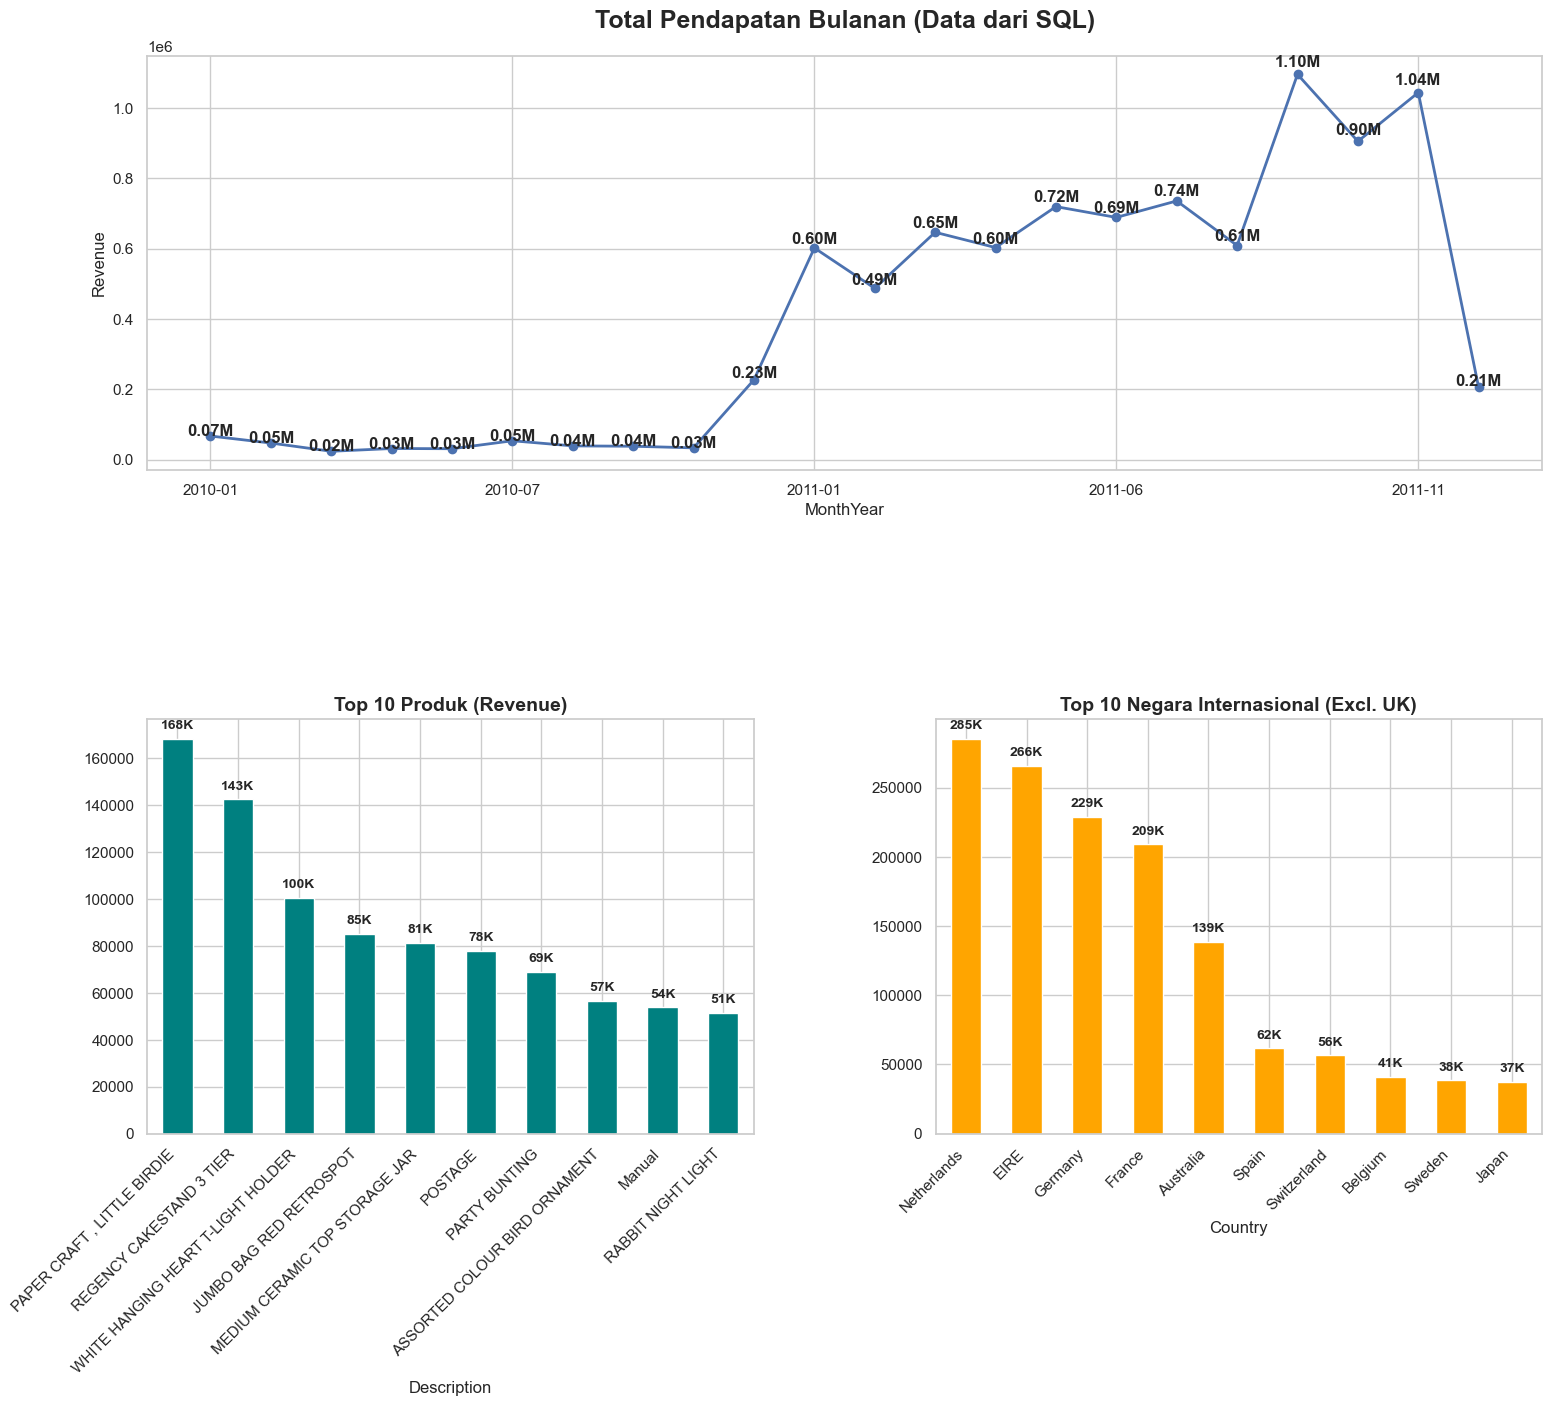

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Memastikan grafik muncul dan tajam
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 

# Inisialisasi ukuran canvas yang besar
fig = plt.figure(figsize=(18, 14))
sns.set(style="whitegrid")

# --- 1. TREN PENJUALAN BULANAN ---
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('MonthYear')['TotalAmount'].sum()

ax1 = plt.subplot(2, 1, 1)
# Mengonversi index Period ke String agar label sumbu X muncul benar
monthly_sales.index = monthly_sales.index.astype(str)
monthly_sales.plot(kind='line', marker='o', color='b', linewidth=2, ax=ax1)

plt.title('Total Pendapatan Bulanan (Data dari SQL)', fontsize=18, pad=20, fontweight='bold')
plt.ylabel('Revenue', fontsize=12)

# Menambahkan Label Angka di atas titik
for i, (idx, val) in enumerate(monthly_sales.items()):
    ax1.text(i, val + (val*0.02), f'{val/1e6:.2f}M', ha='center', fontweight='bold')

# --- 2. TOP 10 PRODUK ---
top_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)
ax2 = plt.subplot(2, 2, 3)
top_products.plot(kind='bar', color='teal', ax=ax2)
plt.title('Top 10 Produk (Revenue)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()/1e3:.0f}K', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', xytext=(0, 5), 
                 textcoords='offset points', fontsize=10, fontweight='bold')

# --- 3. TOP 10 NEGARA ---
top_countries = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)
ax3 = plt.subplot(2, 2, 4)
top_countries.plot(kind='bar', color='orange', ax=ax3)
plt.title('Top 10 Negara Internasional (Excl. UK)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

for p in ax3.patches:
    ax3.annotate(f'{p.get_height()/1e3:.0f}K', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', xytext=(0, 5), 
                 textcoords='offset points', fontsize=10, fontweight='bold')

# Memberi jarak antar grafik agar tidak bertumpuk
plt.subplots_adjust(hspace=0.6, wspace=0.3)

# PAKSA TAMPILKAN
plt.show()

## 8. Key Insights dari Exploratory Data Analysis (EDA)

Berdasarkan visualisasi yang ditarik langsung dari database PostgreSQL, berikut adalah temuan strategis utama untuk manajemen:

### A. Tren Penjualan (Monthly Revenue)
* **Stabilitas Awal & Akselerasi:** Pendapatan bergerak stabil di bawah **0.1M** sepanjang tahun 2010. Pertumbuhan mulai menunjukkan **akselerasi tajam sejak Agustus 2011**.
* **Puncak Performa (Peak Season):** Pendapatan mencapai titik tertinggi historis pada **September 2011** dengan nilai sebesar **1.10M**, diikuti performa kuat pada November 2011 sebesar **1.04M**. Hal ini mengonfirmasi adanya pola musiman yang kuat menjelang akhir tahun (*Holiday Season*).
* **Anomali Desember 2011:** Penurunan angka menjadi **0.21M** di akhir grafik bukan merupakan penurunan performa bisnis, melainkan karena data transaksi pada bulan tersebut **belum lengkap** (hanya mencakup awal bulan).

### B. Dominasi Produk (Top Revenue Products)
* **Produk Unggulan:** **'PAPER CRAFT, LITTLE BIRDIE'** merupakan kontributor pendapatan tunggal terbesar dengan total **168K**, disusul oleh **'REGENCY CAKESTAND 3 TIER'** sebesar **143K**.
* **Strategi Stok:** Mengingat kedua produk ini memiliki gap pendapatan yang signifikan dibandingkan produk lainnya, manajemen inventaris harus memastikan ketersediaan stok (*safety stock*) yang tinggi pada kedua item ini untuk menjaga kelancaran *cash flow*.

### C. Analisis Pasar Internasional (Excl. UK)
* **Pasar Luar Negeri Utama:** **Netherlands** memimpin pasar internasional dengan total kontribusi sebesar **285K**, diikuti oleh **EIRE (Irlandia)** sebesar **266K**, dan **Germany** sebesar **229K**.
* **Peluang Ekspansi:** Dominasi wilayah Eropa menunjukkan efektivitas distribusi di pasar tersebut. Perusahaan disarankan untuk mengoptimalkan logistik dan biaya pengiriman ke wilayah-wilayah ini guna meningkatkan margin profit lebih lanjut.

## 9. Segmentasi Pelanggan (*RFM Analysis*)
Analisis **RFM (Recency, Frequency, Monetary)** adalah teknik pemasaran yang digunakan untuk mengevaluasi nilai pelanggan secara kuantitatif berdasarkan perilaku belanja mereka. 

### Dimensi yang Diukur:
* **Recency (R):** Kesegaran transaksi. Berapa hari yang lalu pelanggan terakhir kali berbelanja? Pelanggan yang baru saja berbelanja lebih cenderung merespons promosi.
* **Frequency (F):** Seberapa sering mereka berbelanja? Ini mencerminkan tingkat loyalitas pelanggan.
* **Monetary (M):** Berapa total nilai transaksi yang dihasilkan? Ini membantu mengidentifikasi pelanggan yang memberikan kontribusi finansial terbesar.

### Tujuan Bisnis:
Segmentasi ini memungkinkan tim pemasaran untuk merancang strategi yang dipersonalisasi, seperti memberikan apresiasi kepada pelanggan setia (*Champions*) atau mengirimkan kampanye reaktivasi untuk pelanggan yang sudah lama tidak berbelanja (*At Risk*).

In [8]:
import datetime as dt

# 1. Menetapkan 'Snapshot Date' (satu hari setelah tanggal transaksi terakhir dalam data)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 2. Menghitung nilai Recency, Frequency, dan Monetary per CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Selisih hari terakhir belanja
    'InvoiceNo': 'count',                                   # Total transaksi
    'TotalAmount': 'sum'                                    # Total pengeluaran
})

# 3. Merapikan nama kolom
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print("--- Langkah 1: Tabel RFM Mentah Berhasil Dibuat ---")
display(rfm.head())

--- Langkah 1: Tabel RFM Mentah Berhasil Dibuat ---


,Recency,Frequency,Monetary
CustomerID,,,
12346,327,1,77183.60
12347,41,182,4310.00
12348,77,31,1797.24
12349,20,73,1757.55
12350,312,17,334.40


>### Analisis Tabel RFM Mentah:
Tabel di atas menyajikan metrik perilaku pelanggan secara objektif sebelum dilakukan proses penskoran. Berdasarkan sampel data tersebut, kita dapat mengidentifikasi beberapa pola awal:
>* **Variasi Recency:** Terdapat perbedaan signifikan dalam interaksi terakhir pelanggan. Sebagai contoh, **CustomerID 12347** sangat aktif dengan *Recency* hanya **2 hari**, sementara **CustomerID 12350** sudah tidak bertransaksi selama **310 hari**.
>* **Intensitas Belanja (Frequency):** **CustomerID 12347** menunjukkan loyalitas yang tinggi dengan **182 transaksi**, jauh melampaui pelanggan lain dalam daftar sampel ini.
>* **Kontribusi Ekonomi (Monetary):** Nilai kontribusi pelanggan sangat bervariasi, di mana **CustomerID 12347** mencatatkan pendapatan tertinggi sebesar **4,310.00**, yang secara linear berkorelasi dengan frekuensi belanjanya yang tinggi.
>Langkah ini sangat krusial karena nilai-nilai mentah inilah yang akan menjadi dasar distribusi dalam pembagian kuartil pada tahap penskoran berikutnya.

### 9.1. Pemberian Skor RFM (*Scoring*)
Setelah mendapatkan nilai absolut untuk Recency, Frequency, dan Monetary, langkah selanjutnya adalah melakukan standardisasi menggunakan metode **Quartiles**. Kita membagi data ke dalam 5 kelompok (skala 1-5) untuk menentukan peringkat relatif setiap pelanggan.

#### Aturan Penilaian:
* **Recency (R):** Semakin kecil nilai hari (baru belanja), semakin tinggi skornya (**Skor 5**).
* **Frequency (F):** Semakin banyak jumlah transaksi, semakin tinggi skornya (**Skor 5**).
* **Monetary (M):** Semakin besar total pengeluaran, semakin tinggi skornya (**Skor 5**).

Pada tahap ini, kita juga membuat kolom **`RFM_Score`** yang menggabungkan ketiga nilai tersebut untuk mempermudah identifikasi profil pelanggan secara cepat (misalnya: skor '555' adalah pelanggan terbaik di semua dimensi).

In [9]:
# 1. Memberikan skor 1-5 menggunakan pd.qcut
# Untuk Recency: angka hari kecil (baru saja belanja) = Skor 5 (Terbaik)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Untuk Frequency: angka transaksi besar = Skor 5 (Terbaik)
# Kita gunakan rank(method='first') untuk menangani nilai yang sama agar pembagian rata
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Untuk Monetary: angka total belanja besar = Skor 5 (Terbaik)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 2. Menggabungkan R, F, M menjadi satu gabungan skor (contoh: '555')
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print("--- Langkah 2: Proses Scoring Selesai ---")
display(rfm.head())

--- Langkah 2: Proses Scoring Selesai ---


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346,327,1,77183.60,1,1,5,115
12347,41,182,4310.00,4,5,5,455
12348,77,31,1797.24,3,3,4,334
12349,20,73,1757.55,4,4,4,444
12350,312,17,334.40,1,2,2,122


> #### Analisis Hasil Scoring (Berdasarkan Sampel Data):
>* **Pelanggan Prioritas (CustomerID 12347):** Memiliki skor **455**. Ini menunjukkan pelanggan yang sangat aktif (R=4) dengan intensitas belanja (F=5) dan kontribusi nilai (M=5) tertinggi. Ini adalah segmen *top-tier* perusahaan.
>* **Potensi Loyalitas (CustomerID 12349):** Dengan skor **444**, pelanggan ini berada di atas rata-rata pada seluruh dimensi secara konsisten, menjadikannya target yang tepat untuk kampanye loyalitas jangka panjang.
>* **Analisis "One-Time Big Spender" (CustomerID 12346):** Memiliki skor unik **115**. Meskipun nilai belanjanya maksimal (M=5), skor *Recency* dan *Frequency* yang rendah (1) menandakan pelanggan ini melakukan pembelian besar satu kali namun sudah sangat lama tidak kembali (berisiko hilang).
>* **Pelanggan Menengah (CustomerID 12348):** Memiliki skor **334**, menunjukkan pelanggan yang memiliki performa rata-rata namun berkontribusi cukup baik secara moneter.
>* **Risiko Kehilangan Pelanggan (CustomerID 12350):** Dengan skor **122**, pelanggan ini menunjukkan aktivitas yang sangat minim di semua aspek dan sudah lama tidak berinteraksi, sehingga memerlukan upaya reaktivasi yang signifikan.
> **Analisis:** Dengan sistem scoring 1-5, kita sekarang memiliki standar perbandingan. Sebagai contoh, pelanggan dengan `RFM_Score` **555** adalah pelanggan ideal (terbaru, tersering, dan belanja terbesar), sedangkan **111** adalah pelanggan yang sudah lama tidak aktif.

### 9.2. Pengelompokan Segmen Pelanggan (*Labeling*)
Pada tahap akhir analisis RFM, kita mengonversi kombinasi skor angka menjadi label kategori yang intuitif. Hal ini bertujuan agar tim bisnis (seperti departemen pemasaran dan penjualan) dapat langsung memahami profil pelanggan tanpa harus menganalisis angka mentah.

#### Definisi Segmen:
* **Champions:** Pelanggan terbaik yang berbelanja baru-baru ini, sangat sering, dan dengan nominal besar.
* **Loyal Customers:** Pelanggan yang setia dan rutin berbelanja.
* **Potential Loyalist:** Pelanggan baru yang berbelanja baru-baru ini dengan frekuensi yang cukup baik.
* **At Risk:** Pelanggan yang dulunya sering berbelanja, tetapi sudah lama tidak kembali. Perlu kampanye reaktivasi.
* **Lost Customers:** Pelanggan dengan skor R dan F terendah yang kemungkinan besar sudah pindah ke kompetitor.
* **Need Attention:** Pelanggan yang berada di kategori rata-rata dan memerlukan dorongan promosi agar menjadi loyal.

Visualisasi di bawah ini memberikan gambaran mengenai komposisi basis pelanggan perusahaan saat ini.

Sukses! Data RFM telah disimpan di PostgreSQL dalam tabel 'rfm_analysis_results'.


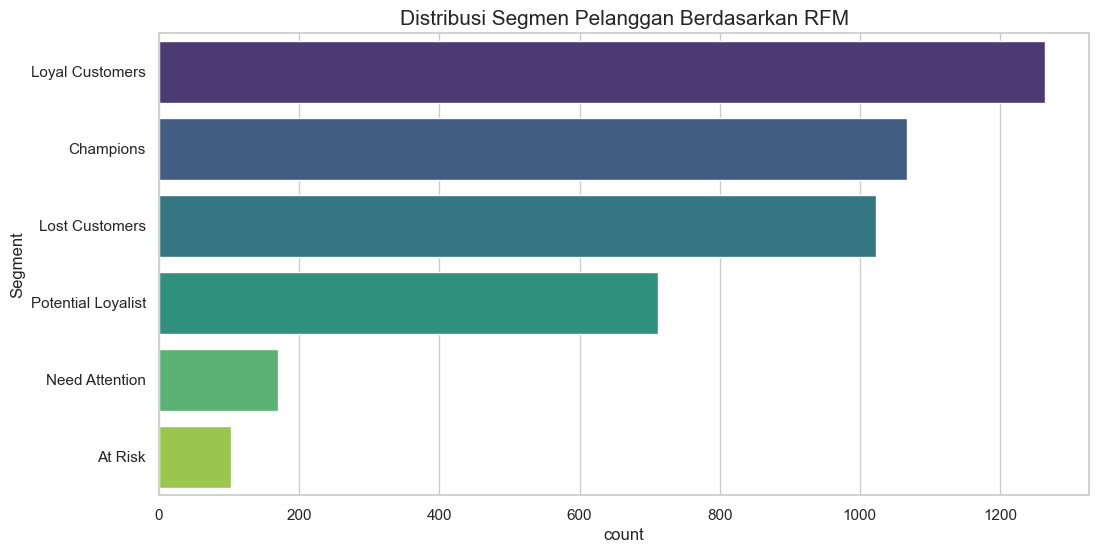


Jumlah pelanggan per segmen:
Loyal Customers       1264
Champions             1067
Lost Customers        1023
Potential Loyalist     712
Need Attention         170
At Risk                102
Name: Segment, dtype: int64


In [10]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Konfigurasi Koneksi Database (Menggunakan pg8000 sesuai settingan Anda)
user = 'postgres'
password = 'Masuk123*' 
host = 'localhost'
port = '5432'
db_name = 'retail_db'

# Membuat engine koneksi
engine = create_engine(f'postgresql+pg8000://{user}:{password}@{host}:{port}/{db_name}')

# 2. Fungsi Logika Segmentasi
def segment_customer(row):
    r = int(row['R'])
    f = int(row['F'])
    
    if (r >= 4) and (f >= 4):
        return 'Champions'
    elif (r >= 2) and (f >= 3):
        return 'Loyal Customers'
    elif (r >= 3) and (f <= 2):
        return 'Potential Loyalist'
    elif (r <= 2) and (f >= 4):
        return 'At Risk'
    elif (r <= 2) and (f <= 2):
        return 'Lost Customers'
    else:
        return 'Need Attention'

# 3. Menerapkan Segmentasi ke DataFrame RFM
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# 4. Mengirim Data RFM ke PostgreSQL
try:
    # Kita simpan ke tabel berbeda agar data transaksi (clean) dan data RFM terpisah
    # index=True karena biasanya CustomerID ada di index dataframe RFM
    rfm.to_sql('rfm_analysis_results', engine, if_exists='replace', index=True)
    print("Sukses! Data RFM telah disimpan di PostgreSQL dalam tabel 'rfm_analysis_results'.")
except Exception as e:
    print(f"Terjadi kesalahan saat mengirim ke database: {e}")

# 5. Visualisasi Distribusi (Opsional untuk pengecekan di Python)
plt.figure(figsize=(12, 6))
sns.countplot(y='Segment', data=rfm, palette='viridis', 
              order=rfm['Segment'].value_counts().index)
plt.title('Distribusi Segmen Pelanggan Berdasarkan RFM', fontsize=15)
plt.show()

print("\nJumlah pelanggan per segmen:")
print(rfm['Segment'].value_counts())

### Strategi Berdasarkan Hasil Segmentasi:
* **Champions & Loyal Customers:** Segmen terbesar kita. Fokus pada program apresiasi (loyalty rewards) agar mereka tetap bertahan dan tidak berpindah ke kompetitor.
* **At Risk:** Ada 102 pelanggan yang berisiko hilang. Kita perlu segera memberikan penawaran khusus atau diskon "We Miss You" untuk mengaktifkan mereka kembali.
* **Lost Customers:** Kelompok ini cukup besar (1.023). Strategi yang tepat adalah melakukan aktivasi melalui email marketing dengan biaya rendah daripada iklan berbayar yang mahal.

## 10. Market Basket Analysis (*Association Rules*)
Setelah memahami profil pelanggan melalui RFM, langkah strategis terakhir adalah memahami **hubungan antar produk**. Dengan mengetahui produk apa yang sering dibeli secara bersamaan, perusahaan dapat mengoptimalkan strategi *Cross-Selling* dan penempatan barang.

### Metodologi: Algoritma Apriori
Analisis ini menggunakan algoritma **Apriori** untuk mengekstraksi aturan asosiasi dari ribuan transaksi. Terdapat tiga metrik utama yang digunakan untuk mengevaluasi kekuatan hubungan produk:

* **Support:** Menunjukkan seberapa populer kombinasi produk tersebut dalam seluruh total transaksi.
* **Confidence:** Mengukur seberapa sering produk B dibeli apabila pelanggan sudah membeli produk A (probabilitas bersyarat).
* **Lift:** Metrik paling krusial yang menunjukkan kekuatan hubungan. Jika nilai **Lift > 1**, maka kedua produk tersebut memiliki hubungan yang kuat dan bukan terjadi secara kebetulan.

### Manfaat Bisnis:
1.  **Product Bundling:** Membuat paket promosi untuk produk yang saling berhubungan.
2.  **Store Layout Optimization:** Meletakkan produk yang berkaitan di lokasi yang berdekatan atau justru berjauhan untuk mendorong pelanggan menjelajahi lebih banyak area.
3.  **Recommendation System:** Memberikan saran produk otomatis pada halaman *checkout* di platform e-commerce.


HASIL MARKET BASKET ANALYSIS (TOP 10 REKOMENDASI)


,antecedents,consequents,support,confidence,lift
81,ALARM CLOCK BAKELIKE RED,"ALARM CLOCK BAKELIKE GREEN, POSTAGE",0.071979,0.756757,8.920557
76,"ALARM CLOCK BAKELIKE GREEN, POSTAGE",ALARM CLOCK BAKELIKE RED,0.071979,0.848485,8.920557
3,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.079692,0.837838,8.576814
2,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.079692,0.815789,8.576814
79,ALARM CLOCK BAKELIKE GREEN,"POSTAGE, ALARM CLOCK BAKELIKE RED",0.071979,0.736842,8.430341
78,"POSTAGE, ALARM CLOCK BAKELIKE RED",ALARM CLOCK BAKELIKE GREEN,0.071979,0.823529,8.430341
6,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE RED,0.074550,0.725000,7.622297
7,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE PINK,0.074550,0.783784,7.622297
118,"SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETROS...",SET/6 RED SPOTTY PAPER PLATES,0.100257,0.975000,7.585500
123,SET/6 RED SPOTTY PAPER PLATES,"SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETROS...",0.100257,0.780000,7.585500


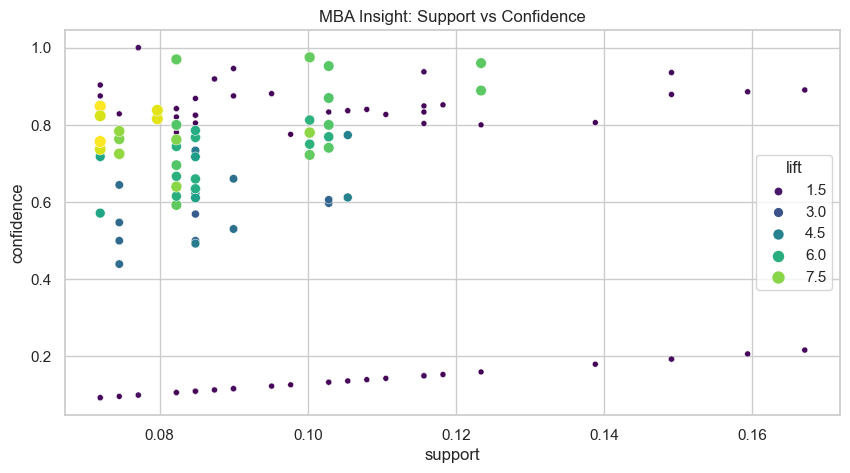


✅ Sukses! Data MBA telah disimpan di PostgreSQL dalam tabel 'mba_analysis_results'.


In [11]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 1. Menyiapkan data basket (Contoh: France)
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# 2. Encoding: Gunakan bool (True/False) untuk menghindari DeprecationWarning
def encode_units(x):
    return x >= 1

basket_sets = basket.applymap(encode_units)

# 3. Menjalankan Algoritma Apriori (min_support 7%)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

# 4. Membangun Aturan Asosiasi
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 5. Persiapan data untuk Tampilan Jupyter & Export (Konversi frozenset ke string)
rules_to_export = rules.copy()
rules_to_export['antecedents'] = rules_to_export['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_to_export['consequents'] = rules_to_export['consequents'].apply(lambda x: ', '.join(list(x)))

# --- TAMPILAN DI JUPYTER NOTEBOOK ---
print("\n" + "="*60)
print("HASIL MARKET BASKET ANALYSIS (TOP 10 REKOMENDASI)")
print("="*60)

# Menampilkan tabel di Jupyter
display(rules_to_export[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        .sort_values('lift', ascending=False).head(10))

# Visualisasi Sederhana untuk Insight Cepat
plt.figure(figsize=(10, 5))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules, palette='viridis')
plt.title('MBA Insight: Support vs Confidence')
plt.show()


# 6. Konfigurasi Koneksi Database (Sesuai settingan Anda)
user = 'postgres'
password = 'Masuk123*' 
host = 'localhost'
port = '5432'
db_name = 'retail_db'

# Menggunakan pg8000 agar tidak error DLL
engine = create_engine(f'postgresql+pg8000://{user}:{password}@{host}:{port}/{db_name}')

# 7. Mengirim Data MBA ke PostgreSQL
try:
    rules_to_export.to_sql('mba_analysis_results', engine, if_exists='replace', index=False)
    print("\n✅ Sukses! Data MBA telah disimpan di PostgreSQL dalam tabel 'mba_analysis_results'.")
except Exception as e:
    print(f"\n❌ Terjadi kesalahan saat mengirim ke database: {e}")

## 11. Interpretasi Market Basket Analysis (MBA)

Berdasarkan tabel asosiasi di atas, kita menemukan pola belanja yang sangat spesifik untuk pasar di Prancis:

* **Hubungan Produk yang Sangat Kuat:** Terdapat korelasi yang signifikan antara **ALARM CLOCK BAKELIKE RED** dan **ALARM CLOCK BAKELIKE GREEN**. Nilai **Lift mencapai 8.92**, yang artinya pelanggan 8.9 kali lebih mungkin membeli jam merah jika mereka sudah membeli jam hijau dibandingkan pembelian secara acak.
* **Confidence Tinggi:** Nilai confidence sebesar **0.84 (84%)** menunjukkan bahwa sebagian besar pelanggan cenderung mengoleksi atau membeli lebih dari satu varian warna untuk produk yang sama.
* **Kaitan dengan Pengiriman:** Produk **POSTAGE** sering muncul dalam aturan asosiasi, ini wajar karena merupakan biaya pengiriman yang menyertai pembelian barang-barang tersebut di pasar internasional.

### Rekomendasi Strategis untuk Tim Produk:
1. **Product Bundling:** Buat paket "Duo Alarm Clock" (Merah & Hijau) dengan harga sedikit lebih murah daripada beli satuan untuk mendorong volume penjualan.
2. **Cross-Selling:** Pada halaman website produk jam beker merah, pastikan produk jam beker hijau muncul di bagian "Pelanggan juga membeli ini".
3. **Optimasi Stok:** Pastikan stok kedua warna ini selalu tersedia bersamaan; jika salah satu habis, kemungkinan besar penjualan warna lainnya juga akan menurun.